# 0 Setup

In [1]:
# =========================
# SETUP CELL
# =========================
from google.colab import drive
import os

drive.mount("/content/drive", force_remount=False)

BASE_DIR = "/content/drive/MyDrive/grunitech-project3-cyberbullying"
DATA_DIR = f"{BASE_DIR}/data"
PROCESSED_DIR = f"{DATA_DIR}/processed"

os.makedirs(PROCESSED_DIR, exist_ok=True)

print("✅ Drive mounted")
print("BASE_DIR:", BASE_DIR)

Mounted at /content/drive
✅ Drive mounted
BASE_DIR: /content/drive/MyDrive/grunitech-project3-cyberbullying


# 1 Dependencies

In [2]:
!pip install -q torch numpy scikit-learn tqdm


# 2 Imports

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


# 3 Load artifacts fron Notebook 3

In [4]:
embeddings = np.load(f"{PROCESSED_DIR}/minilm_embeddings.npy")
confidences = np.load(f"{PROCESSED_DIR}/confidences.npy")
labels = np.load(f"{PROCESSED_DIR}/labels.npy")

strong_bully = np.load(f"{PROCESSED_DIR}/strong_bully_idx.npy")
strong_safe = np.load(f"{PROCESSED_DIR}/strong_safe_idx.npy")
ambiguous = np.load(f"{PROCESSED_DIR}/ambiguous_idx.npy")

print("Embeddings:", embeddings.shape)
print("Strong bully:", strong_bully.sum())
print("Strong safe:", strong_safe.sum())
print("Ambiguous:", ambiguous.sum())


Embeddings: (34020, 384)
Strong bully: 10619
Strong safe: 5669
Ambiguous: 17732


# 4 Cluster sampler

In [21]:
class SyntheticClusterDataset(Dataset):
    def __init__(
        self,
        embeddings,
        confidences,
        bully_idx,
        safe_idx,
        ambig_idx,
        cluster_size=64,
        n_clusters=5000
    ):
        self.emb = embeddings
        self.conf = confidences
        self.bully = np.where(bully_idx)[0]
        self.safe = np.where(safe_idx)[0]
        self.ambig = np.where(ambig_idx)[0]

        self.cluster_size = cluster_size
        self.n_clusters = n_clusters

    def __len__(self):
        return self.n_clusters

    def __getitem__(self, idx):
        # Random bullying ratio
        bully_ratio = np.random.uniform(0, 1)

        n_bully = int(self.cluster_size * bully_ratio)
        n_safe = self.cluster_size - n_bully

        bully_samples = np.random.choice(self.bully, n_bully, replace=True)
        safe_pool = np.concatenate([self.safe, self.ambig])
        safe_samples = np.random.choice(safe_pool, n_safe, replace=True)

        indices = np.concatenate([bully_samples, safe_samples])
        np.random.shuffle(indices)

        cluster_emb = self.emb[indices]
        cluster_conf = self.conf[indices]

        # Cluster label: bullying if enough confident bully messages
        cluster_label = float(cluster_conf.mean())

        return (
            torch.tensor(cluster_emb, dtype=torch.float32),
            torch.tensor(cluster_label, dtype=torch.float32)
        )


# 5 Data loader

In [22]:
dataset = SyntheticClusterDataset(
    embeddings,
    confidences,
    strong_bully,
    strong_safe,
    ambiguous,
    cluster_size=64,
    n_clusters=8000
)

loader = DataLoader(dataset, batch_size=16, shuffle=True)

print("Synthetic clusters ready")


Synthetic clusters ready


# 6 Set-based model (Deep Sets baseline)

In [23]:
class DeepSetClassifier(nn.Module):
    def __init__(self, dim=384, hidden=256):
        super().__init__()
        self.phi = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden)
        )

        self.rho = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):
        # x: [B, N, D]
        h = self.phi(x)              # [B, N, H]
        pooled = h.mean(dim=1)       # permutation invariant
        out = self.rho(pooled)       # [B, 1]
        return out.squeeze(-1)


# 7 Training setup

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DeepSetClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.SmoothL1Loss()

print("Model on:", device)


Model on: cuda


# 8 Training loop

In [25]:
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0.0

    for cluster_emb, cluster_label in tqdm(loader):
        cluster_emb = cluster_emb.to(device)
        cluster_label = cluster_label.to(device)

        optimizer.zero_grad()
        logits = model(cluster_emb)
        loss = criterion(logits, cluster_label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1} | loss = {avg_loss:.4f}")


100%|██████████| 500/500 [00:02<00:00, 198.49it/s]


Epoch 1 | loss = 0.0045


100%|██████████| 500/500 [00:02<00:00, 207.48it/s]


Epoch 2 | loss = 0.0009


100%|██████████| 500/500 [00:02<00:00, 209.16it/s]


Epoch 3 | loss = 0.0007


100%|██████████| 500/500 [00:02<00:00, 209.24it/s]


Epoch 4 | loss = 0.0006


100%|██████████| 500/500 [00:02<00:00, 203.58it/s]


Epoch 5 | loss = 0.0006


100%|██████████| 500/500 [00:02<00:00, 205.95it/s]


Epoch 6 | loss = 0.0006


100%|██████████| 500/500 [00:02<00:00, 208.45it/s]


Epoch 7 | loss = 0.0005


100%|██████████| 500/500 [00:02<00:00, 201.77it/s]


Epoch 8 | loss = 0.0004


100%|██████████| 500/500 [00:02<00:00, 207.22it/s]


Epoch 9 | loss = 0.0004


100%|██████████| 500/500 [00:02<00:00, 203.66it/s]

Epoch 10 | loss = 0.0004


## 8.a. Plotting label distribution and vs model predictions

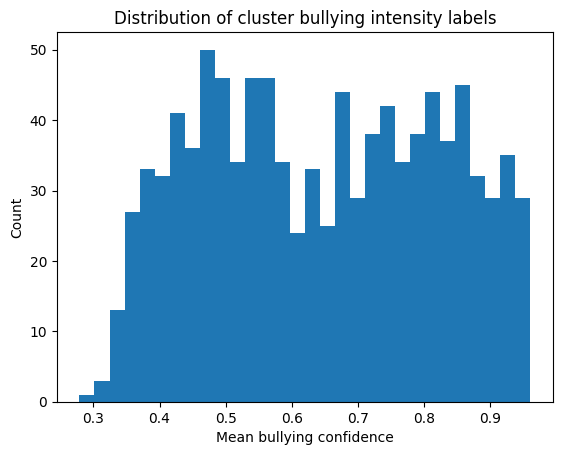

In [31]:
# --- Target distribution (ground truth)

import matplotlib.pyplot as plt

labels = []

for i in range(1000):
    _, y = dataset[i]
    labels.append(y.item())

plt.hist(labels, bins=30)
plt.title("Distribution of cluster bullying intensity labels")
plt.xlabel("Mean bullying confidence")
plt.ylabel("Count")
plt.show()

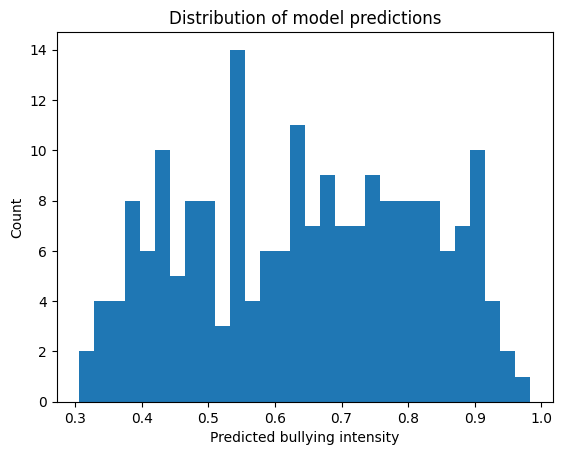

In [30]:
# --- Prediction distribution (model outputs)

preds = []

model.eval()
with torch.no_grad():
    for i in range(200):
        x, _ = dataset[i]
        x = x.unsqueeze(0).to(device)
        preds.append(model(x).item())

plt.hist(preds, bins=30)
plt.title("Distribution of model predictions")
plt.xlabel("Predicted bullying intensity")
plt.ylabel("Count")
plt.show()


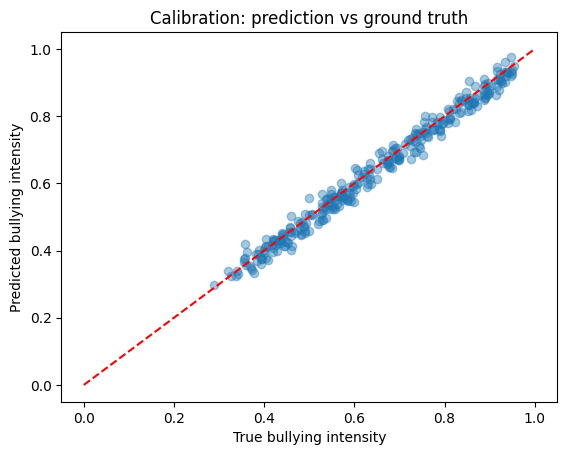

In [32]:
# --- Prediction vs label scatter (MOST IMPORTANT)

ys = []
y_hats = []

model.eval()
with torch.no_grad():
    for i in range(300):
        x, y = dataset[i]
        x = x.unsqueeze(0).to(device)
        ys.append(y.item())
        y_hats.append(model(x).item())

plt.scatter(ys, y_hats, alpha=0.4)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("True bullying intensity")
plt.ylabel("Predicted bullying intensity")
plt.title("Calibration: prediction vs ground truth")
plt.show()


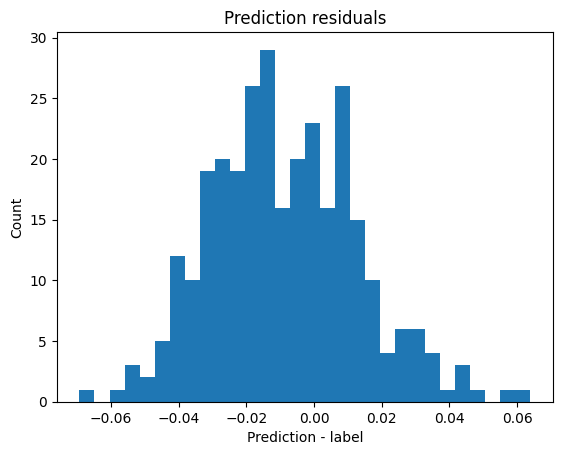

In [33]:
# --- Error distribution (residuals)

residuals = [y_hat - y for y_hat, y in zip(y_hats, ys)]

plt.hist(residuals, bins=30)
plt.title("Prediction residuals")
plt.xlabel("Prediction - label")
plt.ylabel("Count")
plt.show()

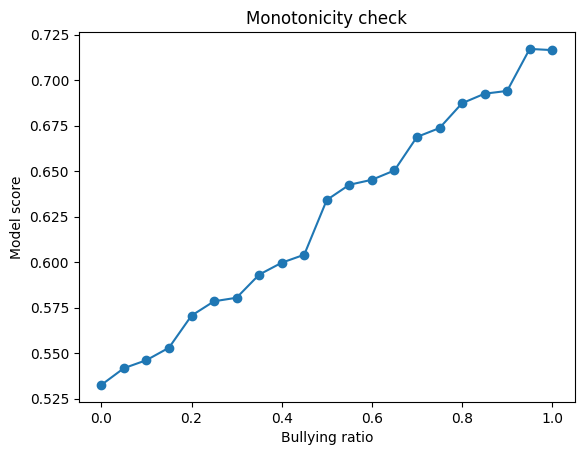

In [34]:
# --- Bucketed monotonicity check (your current test, improved)

import numpy as np

ratios = np.linspace(0, 1, 21)
scores = [test_cluster(r) for r in ratios]

plt.plot(ratios, scores, marker="o")
plt.xlabel("Bullying ratio")
plt.ylabel("Model score")
plt.title("Monotonicity check")
plt.show()


# 9 Sanity test - model responds to bullying ratio?

In [26]:
def test_cluster(bully_ratio):
    n = 64
    n_bully = int(n * bully_ratio)
    n_safe = n - n_bully

    bully_samples = np.random.choice(np.where(strong_bully)[0], n_bully)
    safe_samples = np.random.choice(np.where(strong_safe)[0], n_safe)

    indices = np.concatenate([bully_samples, safe_samples])
    emb = torch.tensor(embeddings[indices], dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        score = torch.sigmoid(model(emb)).item()
    return score


for r in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
    print(f"Bullying ratio {r:.1f} → model score {test_cluster(r):.3f}")


Bullying ratio 0.0 → model score 0.529
Bullying ratio 0.2 → model score 0.562
Bullying ratio 0.4 → model score 0.611
Bullying ratio 0.6 → model score 0.650
Bullying ratio 0.8 → model score 0.687
Bullying ratio 1.0 → model score 0.717


# 10 Save cluster model

In [27]:
MODEL_DIR = f"{BASE_DIR}/models/cluster_model"
os.makedirs(MODEL_DIR, exist_ok=True)

torch.save(model.state_dict(), f"{MODEL_DIR}/deepset_cluster_model.pt")

print("✅ Cluster model saved")


✅ Cluster model saved
